In [ ]:
#https://link.springer.com/article/10.1007/s10044-020-00898-1
#Long short term memory (LSTM) and Temporal convolutional networks (TCN) specialised Models for weather predictions
#

In [37]:
import pandas as pd
from numpy import concatenate
from math import sqrt
from datetime import datetime, date, time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
set_config(display="diagram")


import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df_weather = pd.read_pickle('weatherdata')

In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35063 entries, 16079 to 51141
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   time_now            35063 non-null  datetime64[ns]
 1   temp_now            35063 non-null  float64       
 2   rhum_now            35063 non-null  float64       
 3   dwpt_now            35063 non-null  float64       
 4   pres_now            35063 non-null  float64       
 5   temp_diff           35063 non-null  float64       
 6   rhum_diff           35063 non-null  float64       
 7   dwpt_diff           35063 non-null  float64       
 8   pres_diff           35063 non-null  float64       
 9   tsun_now            34682 non-null  float64       
 10  prcp_now            35063 non-null  float64       
 11  snow_now            35063 non-null  float64       
 12  coco_now            35062 non-null  float64       
 13  tsun_now_next_hour  34682 non-null  float6

## Classifiing current weather conditions
based on current humiditiy dewpoint temperature and pressure and current month

In [32]:
df = df_weather[['date_now','month','temp_now','rhum_now','dwpt_now','pres_now','coco_now']]

In [33]:
#train-test-split
df_train = df[df.date_now <= date(2021,11,30)]
df_test = df[df.date_now > date(2021,11,30)].dropna()

In [34]:
x_train = df_train.drop(['date_now','coco_now'],axis=1)
y_train = df_train.coco_now
x_test = df_test.drop(['coco_now','date_now'],axis=1)
y_test = df_test.coco_now

In [35]:
features = list(x_train.columns)
features

['month', 'temp_now', 'rhum_now', 'dwpt_now', 'pres_now']

In [36]:
#Preprocessing Pipeline: Impute missing values
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['month', 'temp_now', 'rhum_now', 'dwpt_now',
                                  'pres_now'])])

In [37]:
cla = Pipeline(
    steps=[('preprocessor',preprocessor),('knn',SVC())]
)
cla

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [38]:
cla.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['month', 'temp_now',
                                                   'rhum_now', 'dwpt_now',
                                                   'pres_now'])])),
                ('knn', SVC())])

In [39]:
cla.score(x_test,y_test)

0.5028528901017117

In [42]:
predictions = cla.predict(x_test)

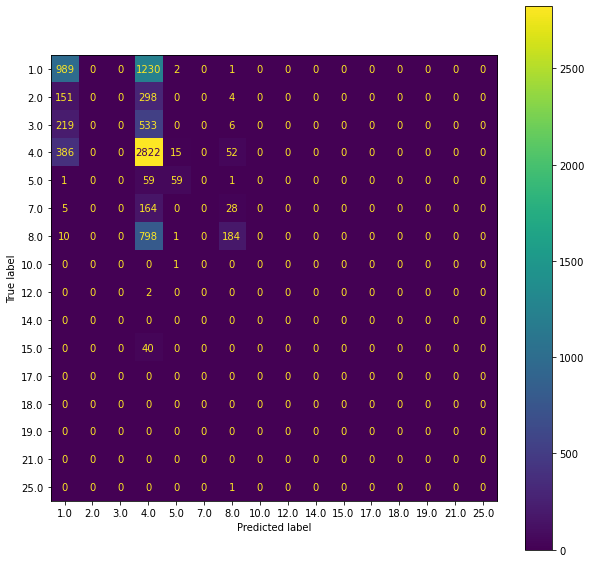

In [49]:
cm = confusion_matrix(y_test, predictions, labels=cla.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cla.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

## Classifing current weather conditions
based on the weather of the last 5 hours and using LSTM
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [91]:
df = df_weather[['time_now','temp_now','rhum_now','dwpt_now','pres_now','coco_now']]
df

,time_now,temp_now,rhum_now,dwpt_now,pres_now,coco_now
16079,2018-11-02 00:00:00,9.3,89.0,7.6,1017.4,4.0
16080,2018-11-02 01:00:00,7.8,91.0,6.4,1018.0,3.0
16081,2018-11-02 02:00:00,7.2,94.0,6.3,1018.3,2.0
16082,2018-11-02 03:00:00,7.0,93.0,5.9,1018.6,1.0
16083,2018-11-02 04:00:00,7.0,92.0,5.8,1019.5,4.0
...,...,...,...,...,...,...
51137,2022-11-01 18:00:00,10.6,82.0,7.7,1021.9,1.0
51138,2022-11-01 19:00:00,11.4,81.0,8.3,1022.1,1.0
51139,2022-11-01 20:00:00,10.9,83.0,8.1,1022.0,1.0
51140,2022-11-01 21:00:00,10.3,87.0,8.2,1022.6,1.0


In [92]:
values = df.drop(['time_now'],axis=1).values
scaler = MinMaxScaler(feature_range=(0,1))
#scaled = scaler.fit_transform(values)

In [93]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [94]:
reframed = series_to_supervised(df.drop('time_now',axis=1), 5)

In [95]:
scaled = scaler.fit_transform(reframed)

In [96]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
16084,9.3,89.0,7.6,1017.4,4.0,7.8,91.0,6.4,1018.0,3.0,7.2,94.0,6.3,1018.3,2.0,7.0,93.0,5.9,1018.6,1.0,7.0,92.0,5.8,1019.5,4.0,6.7,94.0,5.8,1020.0,1.0
16085,7.8,91.0,6.4,1018.0,3.0,7.2,94.0,6.3,1018.3,2.0,7.0,93.0,5.9,1018.6,1.0,7.0,92.0,5.8,1019.5,4.0,6.7,94.0,5.8,1020.0,1.0,5.5,97.0,5.1,1020.7,1.0
16086,7.2,94.0,6.3,1018.3,2.0,7.0,93.0,5.9,1018.6,1.0,7.0,92.0,5.8,1019.5,4.0,6.7,94.0,5.8,1020.0,1.0,5.5,97.0,5.1,1020.7,1.0,6.3,94.0,5.4,1021.6,1.0
16087,7.0,93.0,5.9,1018.6,1.0,7.0,92.0,5.8,1019.5,4.0,6.7,94.0,5.8,1020.0,1.0,5.5,97.0,5.1,1020.7,1.0,6.3,94.0,5.4,1021.6,1.0,8.3,85.0,5.9,1022.5,1.0
16088,7.0,92.0,5.8,1019.5,4.0,6.7,94.0,5.8,1020.0,1.0,5.5,97.0,5.1,1020.7,1.0,6.3,94.0,5.4,1021.6,1.0,8.3,85.0,5.9,1022.5,1.0,9.7,79.0,6.2,1022.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51137,17.2,61.0,9.6,1020.0,2.0,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0
51138,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0
51139,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0
51140,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0,10.3,87.0,8.2,1022.6,1.0


In [97]:
reframed = pd.DataFrame(scaled, columns=reframed.columns)

In [98]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
0,0.427203,0.872093,0.596730,0.568149,0.125000,0.398467,0.895349,0.564033,0.576758,0.083333,0.386973,0.930233,0.561308,0.581062,0.041667,0.383142,0.918605,0.550409,0.585366,0.000,0.383142,0.906977,0.547684,0.598278,0.125,0.377395,0.930233,0.547684,0.605452,0.000
1,0.398467,0.895349,0.564033,0.576758,0.083333,0.386973,0.930233,0.561308,0.581062,0.041667,0.383142,0.918605,0.550409,0.585366,0.000000,0.383142,0.906977,0.547684,0.598278,0.125,0.377395,0.930233,0.547684,0.605452,0.000,0.354406,0.965116,0.528610,0.615495,0.000
2,0.386973,0.930233,0.561308,0.581062,0.041667,0.383142,0.918605,0.550409,0.585366,0.000000,0.383142,0.906977,0.547684,0.598278,0.125000,0.377395,0.930233,0.547684,0.605452,0.000,0.354406,0.965116,0.528610,0.615495,0.000,0.369732,0.930233,0.536785,0.628407,0.000
3,0.383142,0.918605,0.550409,0.585366,0.000000,0.383142,0.906977,0.547684,0.598278,0.125000,0.377395,0.930233,0.547684,0.605452,0.000000,0.354406,0.965116,0.528610,0.615495,0.000,0.369732,0.930233,0.536785,0.628407,0.000,0.408046,0.825581,0.550409,0.641320,0.000
4,0.383142,0.906977,0.547684,0.598278,0.125000,0.377395,0.930233,0.547684,0.605452,0.000000,0.354406,0.965116,0.528610,0.615495,0.000000,0.369732,0.930233,0.536785,0.628407,0.000,0.408046,0.825581,0.550409,0.641320,0.000,0.434866,0.755814,0.558583,0.645624,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35047,0.578544,0.546512,0.651226,0.605452,0.041667,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000,0.505747,0.651163,0.607629,0.624103,0.000,0.452107,0.790698,0.599455,0.632712,0.000
35048,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000,0.452107,0.790698,0.599455,0.632712,0.000,0.467433,0.779070,0.615804,0.635581,0.000
35049,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000,0.467433,0.779070,0.615804,0.635581,0.000,0.457854,0.802326,0.610354,0.634146,0.000
35050,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000,0.457854,0.802326,0.610354,0.634146,0.000,0.446360,0.848837,0.613079,0.642755,0.000


In [99]:
# split into train and test sets
values = reframed.values
n_train_hours = 365* 3 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 29) (26280,) (8772, 1, 29) (8772,)


In [100]:
train_X[1]

array([[0.39846743, 0.89534884, 0.5640327 , 0.57675753, 0.08333333,
        0.38697318, 0.93023256, 0.5613079 , 0.58106169, 0.04166667,
        0.38314176, 0.91860465, 0.55040872, 0.58536585, 0.        ,
        0.38314176, 0.90697674, 0.54768392, 0.59827834, 0.125     ,
        0.37739464, 0.93023256, 0.54768392, 0.60545194, 0.        ,
        0.35440613, 0.96511628, 0.52861035, 0.61549498]])

Epoch 1/50
365/365 - 4s - loss: 0.0513 - val_loss: 0.0405 - 4s/epoch - 11ms/step
Epoch 2/50
365/365 - 1s - loss: 0.0413 - val_loss: 0.0372 - 1s/epoch - 3ms/step
Epoch 3/50
365/365 - 1s - loss: 0.0387 - val_loss: 0.0357 - 1s/epoch - 3ms/step
Epoch 4/50
365/365 - 2s - loss: 0.0380 - val_loss: 0.0363 - 2s/epoch - 4ms/step
Epoch 5/50
365/365 - 1s - loss: 0.0372 - val_loss: 0.0345 - 1s/epoch - 4ms/step
Epoch 6/50
365/365 - 1s - loss: 0.0369 - val_loss: 0.0349 - 1s/epoch - 3ms/step
Epoch 7/50
365/365 - 1s - loss: 0.0367 - val_loss: 0.0353 - 1s/epoch - 4ms/step
Epoch 8/50
365/365 - 1s - loss: 0.0361 - val_loss: 0.0355 - 1s/epoch - 3ms/step
Epoch 9/50
365/365 - 1s - loss: 0.0352 - val_loss: 0.0336 - 1s/epoch - 4ms/step
Epoch 10/50
365/365 - 1s - loss: 0.0361 - val_loss: 0.0351 - 1s/epoch - 4ms/step
Epoch 11/50
365/365 - 2s - loss: 0.0353 - val_loss: 0.0343 - 2s/epoch - 5ms/step
Epoch 12/50
365/365 - 1s - loss: 0.0362 - val_loss: 0.0358 - 1s/epoch - 3ms/step
Epoch 13/50
365/365 - 1s - loss: 0.0

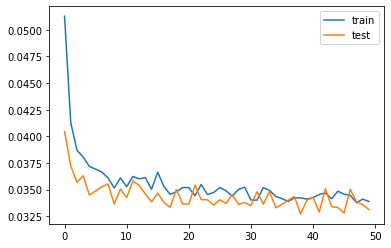

In [101]:
#designing the network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                16000     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16,051
Trainable params: 16,051
Non-trainable params: 0
_________________________________________________________________


In [103]:
pred = model.predict(test_X)
pred

275/275 [==============================] - 2s 4ms/step


array([[ 0.29278883],
       [ 0.28994662],
       [ 0.29096055],
       ...,
       [-0.0010392 ],
       [-0.0013691 ],
       [-0.00171296]], dtype=float32)

In [104]:
test_X

array([[[0.51532567, 0.8372093 , 0.70572207, ..., 0.95348837,
         0.67847411, 0.38020086]],

       [[0.50957854, 0.89534884, 0.72207084, ..., 0.93023256,
         0.66212534, 0.38593974]],

       [[0.48659004, 0.8255814 , 0.65940054, ..., 0.95348837,
         0.65940054, 0.39167862]],

       ...,

       [[0.57279693, 0.54651163, 0.64305177, ..., 0.80232558,
         0.61035422, 0.63414634]],

       [[0.5440613 , 0.56976744, 0.61852861, ..., 0.84883721,
         0.61307902, 0.64275466]],

       [[0.50574713, 0.65116279, 0.60762943, ..., 0.86046512,
         0.61307902, 0.64705882]]])

In [105]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X

array([[0.51532567, 0.8372093 , 0.70572207, ..., 0.95348837, 0.67847411,
        0.38020086],
       [0.50957854, 0.89534884, 0.72207084, ..., 0.93023256, 0.66212534,
        0.38593974],
       [0.48659004, 0.8255814 , 0.65940054, ..., 0.95348837, 0.65940054,
        0.39167862],
       ...,
       [0.57279693, 0.54651163, 0.64305177, ..., 0.80232558, 0.61035422,
        0.63414634],
       [0.5440613 , 0.56976744, 0.61852861, ..., 0.84883721, 0.61307902,
        0.64275466],
       [0.50574713, 0.65116279, 0.60762943, ..., 0.86046512, 0.61307902,
        0.64705882]])

In [111]:
inv_yhat = concatenate((test_X, pred), axis=1)
inv_yhat

array([[ 0.51532567,  0.8372093 ,  0.70572207, ...,  0.67847411,
         0.38020086,  0.29278883],
       [ 0.50957854,  0.89534884,  0.72207084, ...,  0.66212534,
         0.38593974,  0.28994662],
       [ 0.48659004,  0.8255814 ,  0.65940054, ...,  0.65940054,
         0.39167862,  0.29096055],
       ...,
       [ 0.57279693,  0.54651163,  0.64305177, ...,  0.61035422,
         0.63414634, -0.0010392 ],
       [ 0.5440613 ,  0.56976744,  0.61852861, ...,  0.61307902,
         0.64275466, -0.0013691 ],
       [ 0.50574713,  0.65116279,  0.60762943, ...,  0.61307902,
         0.64705882, -0.00171296]])

In [113]:
test_scaled = pd.DataFrame(inv_yhat,columns=['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)','pred'])
test_scaled

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),pred
0,0.515326,0.837209,0.705722,0.348637,0.125000,0.509579,0.895349,0.722071,0.358680,0.291667,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.292789
1,0.509579,0.895349,0.722071,0.358680,0.291667,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.289947
2,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.290961
3,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.250000,0.455939,0.895349,0.645777,0.398852,0.249278
4,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.250000,0.455939,0.895349,0.645777,0.398852,0.291667,0.457854,0.848837,0.629428,0.394548,0.288371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.578544,0.546512,0.651226,0.605452,0.041667,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,-0.000087
8768,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,-0.001193
8769,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000000,0.457854,0.802326,0.610354,0.634146,-0.001039
8770,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000000,0.457854,0.802326,0.610354,0.634146,0.000000,0.446360,0.848837,0.613079,0.642755,-0.001369


In [114]:
test = scaler.inverse_transform(test_scaled)
test

array([[1.39000000e+01, 8.60000000e+01, 1.16000000e+01, ...,
        1.06000000e+01, 1.00430000e+03, 8.02693200e+00],
       [1.36000000e+01, 9.10000000e+01, 1.22000000e+01, ...,
        1.00000000e+01, 1.00470000e+03, 7.95871878e+00],
       [1.24000000e+01, 8.50000000e+01, 9.90000000e+00, ...,
        9.90000000e+00, 1.00510000e+03, 7.98305321e+00],
       ...,
       [1.69000000e+01, 6.10000000e+01, 9.30000000e+00, ...,
        8.10000000e+00, 1.02200000e+03, 9.75059211e-01],
       [1.54000000e+01, 6.30000000e+01, 8.40000000e+00, ...,
        8.20000000e+00, 1.02260000e+03, 9.67141710e-01],
       [1.34000000e+01, 7.00000000e+01, 8.00000000e+00, ...,
        8.20000000e+00, 1.02290000e+03, 9.58888844e-01]])

In [115]:
test = pd.DataFrame(test, columns= test_scaled.columns) 

In [116]:
test

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),pred
0,13.9,86.0,11.6,1002.1,4.0,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.026932
1,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,7.958719
2,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.983053
3,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,6.982664
4,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,8.0,10.9,87.0,8.8,1005.3,7.920911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,9.6,1020.0,2.0,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,0.997917
8768,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,0.971358
8769,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,0.975059
8770,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0,10.3,87.0,8.2,1022.6,0.967142


In [122]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X, test_y), axis=1)
inv_y 

array([[0.51532567, 0.8372093 , 0.70572207, ..., 0.67847411, 0.38020086,
        0.29166667],
       [0.50957854, 0.89534884, 0.72207084, ..., 0.66212534, 0.38593974,
        0.29166667],
       [0.48659004, 0.8255814 , 0.65940054, ..., 0.65940054, 0.39167862,
        0.25      ],
       ...,
       [0.57279693, 0.54651163, 0.64305177, ..., 0.61035422, 0.63414634,
        0.        ],
       [0.5440613 , 0.56976744, 0.61852861, ..., 0.61307902, 0.64275466,
        0.        ],
       [0.50574713, 0.65116279, 0.60762943, ..., 0.61307902, 0.64705882,
        0.125     ]])

In [124]:
inv_y = pd.DataFrame(inv_y, columns=['var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)',
       'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)',
       'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)',
       'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)','actual'])

In [125]:
inv_y

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),actual
0,0.515326,0.837209,0.705722,0.348637,0.125000,0.509579,0.895349,0.722071,0.358680,0.291667,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667
1,0.509579,0.895349,0.722071,0.358680,0.291667,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667
2,0.486590,0.825581,0.659401,0.373027,0.291667,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.250000
3,0.467433,0.906977,0.664850,0.361549,0.291667,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.250000,0.455939,0.895349,0.645777,0.398852,0.291667
4,0.463602,0.953488,0.678474,0.373027,0.291667,0.463602,0.953488,0.678474,0.380201,0.291667,0.457854,0.930233,0.662125,0.385940,0.291667,0.450192,0.953488,0.659401,0.391679,0.250000,0.455939,0.895349,0.645777,0.398852,0.291667,0.457854,0.848837,0.629428,0.394548,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,0.578544,0.546512,0.651226,0.605452,0.041667,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000
8768,0.588123,0.534884,0.656676,0.606887,0.000000,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000000
8769,0.572797,0.546512,0.643052,0.611191,0.083333,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000000,0.457854,0.802326,0.610354,0.634146,0.000000
8770,0.544061,0.569767,0.618529,0.615495,0.000000,0.505747,0.651163,0.607629,0.624103,0.000000,0.452107,0.790698,0.599455,0.632712,0.000000,0.467433,0.779070,0.615804,0.635581,0.000000,0.457854,0.802326,0.610354,0.634146,0.000000,0.446360,0.848837,0.613079,0.642755,0.000000


In [126]:
test_actual = scaler.inverse_transform(inv_y)
test_actual

array([[1.3900e+01, 8.6000e+01, 1.1600e+01, ..., 1.0600e+01, 1.0043e+03,
        8.0000e+00],
       [1.3600e+01, 9.1000e+01, 1.2200e+01, ..., 1.0000e+01, 1.0047e+03,
        8.0000e+00],
       [1.2400e+01, 8.5000e+01, 9.9000e+00, ..., 9.9000e+00, 1.0051e+03,
        7.0000e+00],
       ...,
       [1.6900e+01, 6.1000e+01, 9.3000e+00, ..., 8.1000e+00, 1.0220e+03,
        1.0000e+00],
       [1.5400e+01, 6.3000e+01, 8.4000e+00, ..., 8.2000e+00, 1.0226e+03,
        1.0000e+00],
       [1.3400e+01, 7.0000e+01, 8.0000e+00, ..., 8.2000e+00, 1.0229e+03,
        4.0000e+00]])

In [127]:
test_actual = pd.DataFrame(test_actual, columns = inv_y.columns)
test_actual

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),actual
0,13.9,86.0,11.6,1002.1,4.0,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0
1,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0
2,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0
3,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,8.0
4,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,8.0,10.9,87.0,8.8,1005.3,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,9.6,1020.0,2.0,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0
8768,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0
8769,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0
8770,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0,10.3,87.0,8.2,1022.6,1.0


In [128]:
test['actual'] = test_actual.actual
test

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),pred,actual
0,13.9,86.0,11.6,1002.1,4.0,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.026932,8.0
1,13.6,91.0,12.2,1002.8,8.0,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,7.958719,8.0
2,12.4,85.0,9.9,1003.8,8.0,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.983053,7.0
3,11.4,92.0,10.1,1003.0,8.0,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,6.982664,8.0
4,11.2,96.0,10.6,1003.8,8.0,11.2,96.0,10.6,1004.3,8.0,10.9,94.0,10.0,1004.7,8.0,10.5,96.0,9.9,1005.1,7.0,10.8,91.0,9.4,1005.6,8.0,10.9,87.0,8.8,1005.3,7.920911,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,17.2,61.0,9.6,1020.0,2.0,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,0.997917,1.0
8768,17.7,60.0,9.8,1020.1,1.0,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,0.971358,1.0
8769,16.9,61.0,9.3,1020.4,3.0,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,0.975059,1.0
8770,15.4,63.0,8.4,1020.7,1.0,13.4,70.0,8.0,1021.3,1.0,10.6,82.0,7.7,1021.9,1.0,11.4,81.0,8.3,1022.1,1.0,10.9,83.0,8.1,1022.0,1.0,10.3,87.0,8.2,1022.6,0.967142,1.0


In [132]:
test.sample(20)

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),pred,actual
4381,18.1,55.0,8.9,1016.2,4.0,19.4,49.0,8.4,1015.5,4.0,19.4,50.0,8.7,1015.2,4.0,19.3,48.0,8.0,1014.8,4.0,19.2,47.0,7.6,1014.5,4.0,18.5,52.0,8.5,1014.6,3.990295,4.0
3020,3.8,50.0,-5.7,1024.1,4.0,3.4,47.0,-6.9,1024.5,4.0,3.2,46.0,-7.3,1024.9,4.0,2.6,49.0,-7.1,1025.1,4.0,2.4,48.0,-7.5,1025.0,4.0,2.2,49.0,-7.4,1025.1,3.976398,4.0
2542,7.2,91.0,5.8,1010.0,4.0,7.3,90.0,5.8,1010.2,4.0,6.7,91.0,5.3,1010.3,4.0,5.6,93.0,4.6,1010.6,4.0,5.3,94.0,4.4,1010.6,4.0,5.6,93.0,4.6,1010.7,3.981965,4.0
3282,8.9,83.0,6.2,1032.3,4.0,9.2,72.0,4.4,1032.9,4.0,9.1,72.0,4.3,1033.8,4.0,9.0,71.0,4.0,1034.6,4.0,8.4,71.0,3.4,1035.1,4.0,7.5,73.0,3.0,1035.5,3.895007,4.0
1636,1.6,95.0,0.9,1009.0,7.0,1.7,93.0,0.7,1010.3,8.0,1.5,95.0,0.8,1012.8,7.0,1.8,93.0,0.8,1014.0,15.0,1.8,90.0,0.3,1015.4,4.0,2.9,79.0,-0.4,1016.1,3.963822,4.0
584,1.9,81.0,-1.0,1012.8,4.0,2.0,79.0,-1.3,1013.0,4.0,2.1,79.0,-1.2,1012.6,4.0,2.1,77.0,-1.5,1012.6,4.0,2.4,76.0,-1.4,1012.5,4.0,2.3,78.0,-1.1,1011.8,3.991389,4.0
1343,3.0,99.0,2.9,1006.0,8.0,3.2,98.0,2.9,1005.9,7.0,3.4,99.0,3.3,1005.6,8.0,3.4,99.0,3.3,1005.7,4.0,3.8,98.0,3.5,1005.2,4.0,4.5,99.0,4.4,1005.0,4.036251,8.0
5100,21.1,35.0,5.0,1014.5,4.0,23.3,26.0,2.7,1014.0,2.0,23.5,29.0,4.4,1013.8,3.0,23.6,29.0,4.5,1013.8,2.0,23.8,27.0,3.7,1013.8,2.0,22.7,27.0,2.7,1014.0,2.009928,1.0
149,4.9,94.0,4.0,1023.2,4.0,5.3,90.0,3.8,1021.8,4.0,5.3,89.0,3.6,1021.7,4.0,5.6,87.0,3.6,1021.6,4.0,5.7,90.0,4.2,1021.4,7.0,6.2,89.0,4.5,1021.2,6.922650,8.0
7167,23.3,64.0,16.1,1013.6,4.0,22.7,66.0,16.0,1013.9,4.0,22.2,67.0,15.8,1014.0,4.0,22.0,69.0,16.1,1014.0,4.0,21.3,72.0,16.0,1013.9,8.0,21.0,73.0,16.0,1013.8,7.827405,8.0


<function matplotlib.pyplot.show(close=None, block=None)>

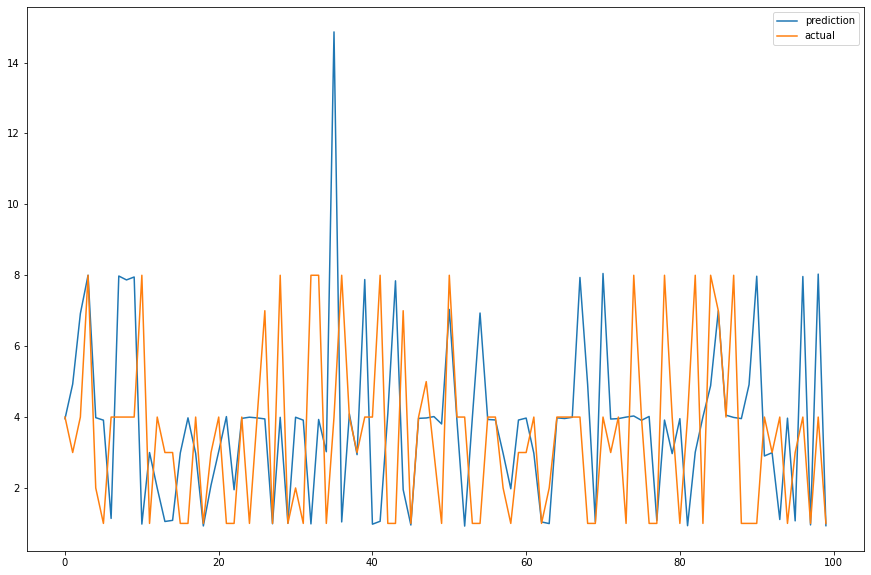

In [146]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plt.plot([i for i in range(100)],test.sample(100).pred,label = 'prediction')
plt.plot([i for i in range(100)], test.sample(100).actual, label = 'actual')
plt.legend()
plt.show

In [130]:
# calculate rsme
rsme = sqrt(mean_squared_error(test_y,pred))

In [131]:
rsme

0.06661279631670215